In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import pandas as pd
import datetime as dt
import pydot
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn import tree
import sys
from graphviz import Source

mask_directory = '/Users/kathum/Research/COPEX/sink_region_files/masks'
WAM_files = '/Volumes/LaCie_10TB_Keys_KH/era5/output/backtrack/co_altclimate_nfr_2000_2023/'
sink_region_name = 'nfr'

## Open Labels and Inputs

In [44]:
# MODIFY----------
label_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/nfr_daily_precip.csv'
#input_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/nfr_daily_e_track.csv'
input_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/lagged_30_nfr_daily_e_track.csv'
local_path = '/Users/kathum/Classes/fall_2024/Data_driven Analysis/Data_Driven_Prediction/figures/'
nfr_mask = xr.open_dataarray('/Users/kathum/Research/COPEX/sink_region_files/masks/co_AltClimate_Northern_Front_Range_source_region.nc')
area = xr.open_dataarray('/Users/kathum/Research/area_grids/quarter_degree_area_grid_all_lat_lon.nc')
nfr_area = (area*nfr_mask).sum(['latitude', 'longitude']).values
mm = True
#-----------------

X = pd.read_csv(input_path).iloc[:,1:] #remove first column in csv
y = pd.read_csv(label_path).iloc[:,1:] #remove first column in csv

if mm:
    y['nfr_precip_inch'] = (y['nfr_precip_m3']/nfr_area)*39.37
    y = y.loc[:,['Date', 'nfr_precip_inch']]

# print('--- FEATURES ---')
# print(X.head())
# #feature_names = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
# print('--- LABELS ---')
# print(y.head())
#classes = ['Adelie', 'Chinstrap', 'Gentoo'] # These are the penguin species


In [45]:

y

Date  nfr_precip_inch
0     2000-01-01         0.002465
1     2000-01-02         0.050050
2     2000-01-03         0.120979
3     2000-01-04         0.000121
4     2000-01-05         0.004503
...          ...              ...
8669  2023-09-26         0.000261
8670  2023-09-27         0.000000
8671  2023-09-28         0.001344
8672  2023-09-29         0.000447
8673  2023-09-30         0.001755

[8674 rows x 2 columns]

In [46]:
X_train = X.loc[(X['Date'] >= '2000-01-01') & (X['Date'] < "2018-01-01"), X.columns != 'Date']#, X.columns != 'date']
y_train = y.loc[(y['Date'] >= '2000-01-01') & (y['Date'] < "2018-01-01"), y.columns != 'Date']#, y.columns != 'Date' ]
X_val = X.loc[(X['Date'] >= "2018-01-01") & (X['Date'] < "2022-01-01"), X.columns != 'Date']#, X.columns != 'date' ]
y_val = y.loc[(y['Date'] >= '2018-01-01') & (y['Date'] < "2022-01-01"), y.columns != 'Date']#, y.columns != 'Date' ]
# Commented lines below are to look at the split data
print('--- TRAINING ---')
print(X_train.iloc[[0,1,2,-3,-2,-1],:])
print(y_train.iloc[[0,1,2,-3,-2,-1],:])
print('--- VALIDATION ---')
print(X_val.iloc[[0,1,2,-3,-2,-1],:])
print(y_val.iloc[[0,1,2,-3,-2,-1],:])


--- TRAINING ---
      Other Water_e_track_t-0  Pacific Ocean_e_track_t-0  \
0                 8042.574794               4.349085e+06   
1                10999.343513               4.396600e+06   
2                14548.744700               4.230650e+06   
6572             33670.493236               2.775213e+06   
6573             24804.565089               2.944741e+06   
6574             26515.948910               4.068605e+06   

      Gulf of California_e_track_t-0  Atlantic Ocean_e_track_t-0  \
0                        6382.884692                8.545996e+05   
1                       21491.728424                1.084664e+06   
2                       53290.881233                1.214330e+06   
6572                    16890.363976                1.271335e+05   
6573                    13219.163438                7.706740e+04   
6574                    17191.952972                4.559170e+04   

      Gulf of Mexico_e_track_t-0  Other Land_e_track_t-0  \
0                    1934

In [47]:
### MODIFY HYPERPARAMETERS WITHIN THIS CELL
fd = {
    "tree_number": 15,    # number of trees to "average" together to create a random forest
    "tree_depth": 5,      # maximum depth allowed for each tree
    "node_split": 20,     # minimum number of training samples needed to split a node
    "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
    "criterion": 'squared_error',  # information gain metric, 'gini' or 'entropy'
    "bootstrap": False,   # whether to perform "bagging=bootstrap aggregating" or not
    "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None
    "random_state": 13    # set random state for reproducibility
}

### Default values are retained below for reference
# fd = {
#     "tree_number": 15,    # number of trees to "average" together to create a random forest
#     "tree_depth": 5,      # maximum depth allowed for each tree
#     "node_split": 20,     # minimum number of training samples needed to split a node
#     "leaf_samples": 1,    # minimum number of training samples required to make a leaf node
#     "criterion": 'gini',  # information gain metric, 'gini' or 'entropy'
#     "bootstrap": False,   # whether to perform "bagging=bootstrap aggregating" or not
#     "max_samples": None,  # number of samples to grab when training each tree IF bootstrap=True, otherwise None
#     "random_state": 13    # set random state for reproducibility
# }

In [48]:
forest = RandomForestRegressor(
                           n_estimators = fd["tree_number"],
                           random_state = fd["random_state"],
                           min_samples_split = fd["node_split"],
                           min_samples_leaf = fd["leaf_samples"],
                           criterion = fd["criterion"],
                           max_depth = fd["tree_depth"],
                           bootstrap = fd["bootstrap"],
                           max_samples = fd["max_samples"])

In [49]:
forest.fit(X_train, y_train) # Runs the forest classifier
y_pred = forest.predict(X_train)
y_pred_val = forest.predict(X_val)


/Users/kathum/anaconda3/envs/wamenv/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [50]:
len(dates)
X.loc[(X['Date'] >= "2018-01-01") & (X['Date'] <"2022-01-01"), X.columns == 'Date']

Date
6575  2018-01-01 00:00:00
6576  2018-01-02 00:00:00
6577  2018-01-03 00:00:00
6578  2018-01-04 00:00:00
6579  2018-01-05 00:00:00
...                   ...
8031  2021-12-27 00:00:00
8032  2021-12-28 00:00:00
8033  2021-12-29 00:00:00
8034  2021-12-30 00:00:00
8035  2021-12-31 00:00:00

[1461 rows x 1 columns]

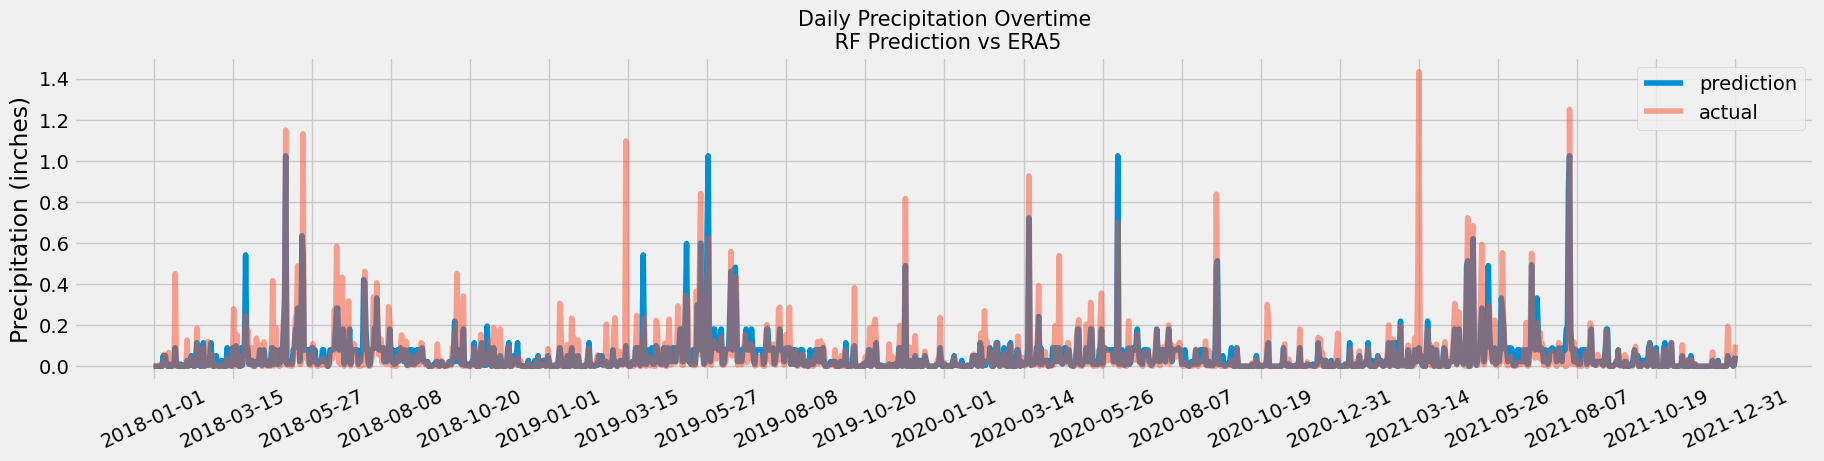

In [53]:
dates = y.loc[(y['Date'] >= "2018-01-01") & (y['Date'] <= "2021-12-31"), y.columns == 'Date'].values.squeeze()
fig, ax =plt.subplots(figsize=(20, 4))
plt.plot(dates,y_pred_val, label = 'prediction')
plt.plot(dates, y_val.values.squeeze(), alpha = 0.5, label = 'actual')
plt.ylabel('Precipitation (inches)')
plt.title('Daily Precipitation Overtime\n RF Prediction vs ERA5', fontdict={'fontsize':15})
plt.legend()
ax.set_xticks(ax.get_xticks()[::73])
plt.xticks(rotation = 25)

plt.savefig(local_path+'daily_precip_RF_predict_2018_2021.png', dpi = 400,bbox_inches="tight")
print('')

In [56]:
#cacluate RMSE
from sklearn.metrics import root_mean_squared_error
print('----Validation Data------')
print('RF RMSE:',f'{round(root_mean_squared_error(y_val, y_pred_val),2):,}', 'in')
print('No Precip RMSE:',f'{round(root_mean_squared_error([0] * len(y_val), y_pred_val),2):,}', 'in')
print('----Training Data------')
print('RF RMSE:',f'{round(root_mean_squared_error(y_train, y_pred),2):,}', 'in')
print('No Precip RMSE:',f'{round(root_mean_squared_error([0] * len(y_pred), y_pred),2):,}', 'in')



----Validation Data------
RF RMSE: 0.08 in
No Precip RMSE: 0.11 in
----Training Data------
RF RMSE: 0.06 in
No Precip RMSE: 0.12 in


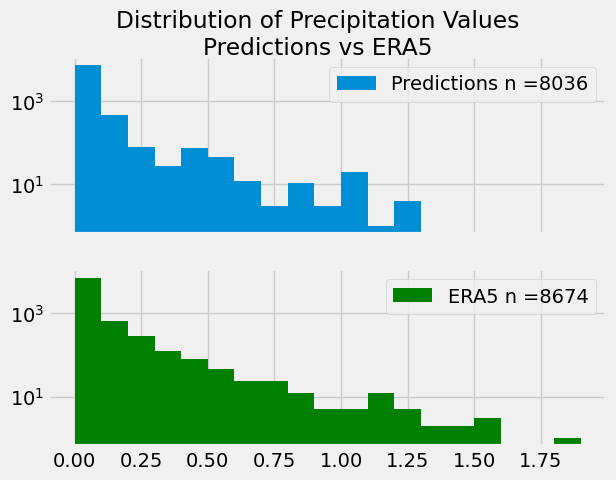

In [81]:
all_predictions = np.append(y_pred,y_pred_val)
binwidth = 0.10
bins = np.arange(0, max(y.iloc[:,1])+binwidth, binwidth)
fig, axs = plt.subplots(2, sharey=True, sharex=True)
axs[0].hist(all_predictions, bins = bins, label = f"Predictions n ={len(all_predictions)}")
axs[0].set_yscale('log')
axs[0].legend()

axs[1].hist(y.iloc[:,1], bins = bins,color = 'green', label = f"ERA5 n ={len(y.iloc[:,1])}")
axs[1].set_yscale('log')
axs[1].legend()

plt.suptitle('Distribution of Precipitation Values\nPredictions vs ERA5')


plt.savefig(local_path+'Histogram_predict_vs_era5.png', dpi = 400,bbox_inches="tight")


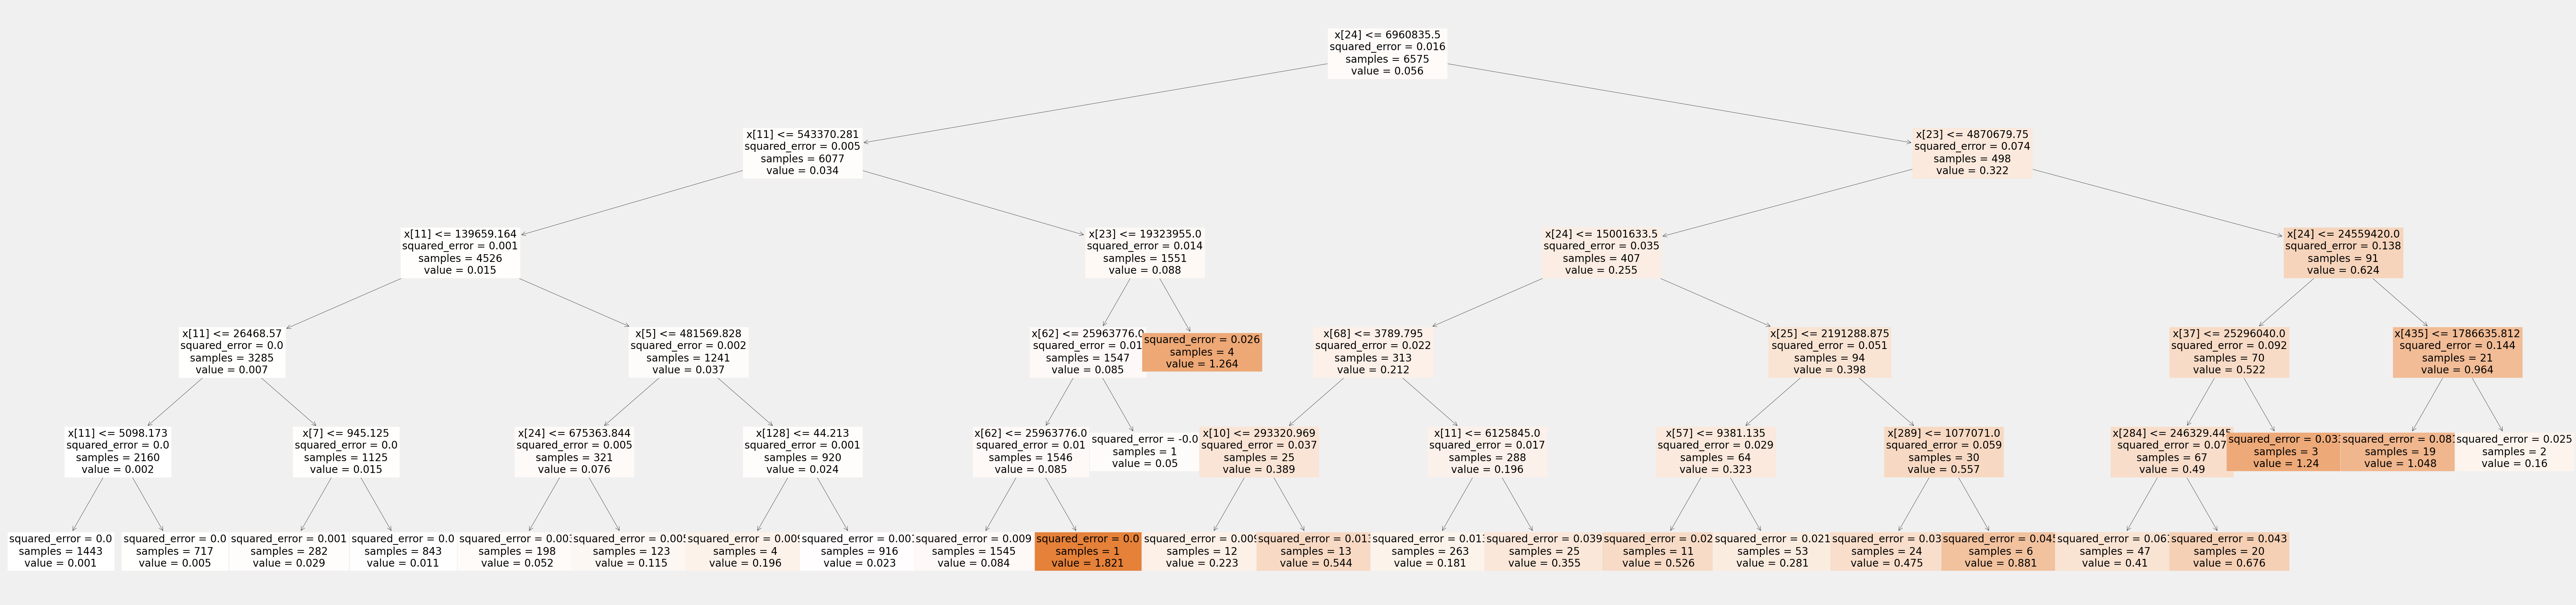

In [82]:
plt.figure(figsize=(80,20))
tree.plot_tree(forest.estimators_[0], filled = True, fontsize=20)
print('')

In [83]:
X_train.iloc[:,11]

0       170407.811859
1       547892.229126
2       374064.360107
3          129.981162
4         6105.731972
            ...      
6570       220.751777
6571      2471.099488
6572       455.889158
6573       838.070293
6574     19587.976670
Name: Front Range_e_track_t-0, Length: 6575, dtype: float64

In [86]:
list(X.columns)[1:][24]

'Colorado_e_track_t-1'

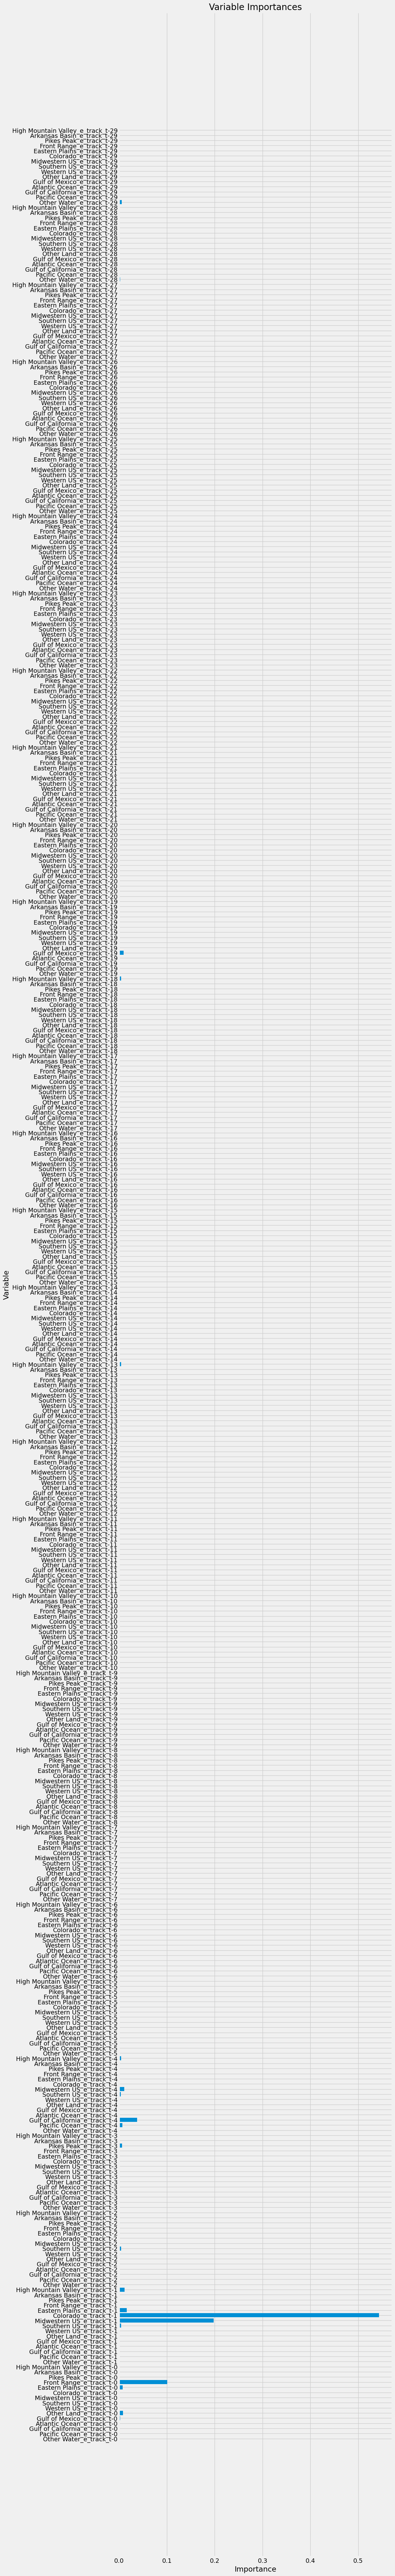

In [85]:
def calc_importances(rf, feature_list):
    ''' Calculate feature importance '''
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances
    # print('')
    # [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    # print('')

    return importances

def plot_feat_importances(importances, feature_list):
    ''' Plot the feature importance calculated by calc_importances '''
    plt.figure(figsize=(10,100))
    # Set the style
    plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances)
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')

feature_names = list(X.columns)[1:]
importantces_vars = calc_importances(forest, feature_names)
plot_feat_importances(importantces_vars,  feature_names)
plt.savefig(local_path+'variable_importances.png', dpi = 400,bbox_inches="tight")